# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [9]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [11]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 2, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:10], train_y[:10])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:10], train_y[:10])

Checking gradient for layer_1.0_W
Gradient check passed!
Checking gradient for layer_1.0_B
Gradient check passed!
Checking gradient for layer_2.0_W
Gradient check passed!
Checking gradient for layer_2.0_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [12]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e-1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:10], train_y[:10])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:10], train_y[:10])

Checking gradient for layer_1.0_W
Gradient check passed!
Checking gradient for layer_1.0_B
Gradient check passed!
Checking gradient for layer_2.0_W
Gradient check passed!
Checking gradient for layer_2.0_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [13]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.06666666666666667

In [14]:
def display_history(train_history, val_history, loss_history):
    plt.figure(figsize=(14, 5))
    plt.subplot('121')
    plt.title("Train/Validation accuracy")
    plt.plot(train_history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.subplot('122')
    plt.title("Loss")
    plt.plot(loss_history, label='loss')
    plt.legend();

# Допишем код для процесса тренировки

In [24]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = .25e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=.25e-1, num_epochs=30)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down and train and val accuracy go up for every epoch
loss_history, train_history, val_history = trainer.fit()

Loss: 2.256315, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.231389, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.216133, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.163351, Train accuracy: 0.244556, val accuracy: 0.249000
Loss: 2.091889, Train accuracy: 0.272333, val accuracy: 0.270000
Loss: 1.992203, Train accuracy: 0.331333, val accuracy: 0.333000
Loss: 1.871460, Train accuracy: 0.389000, val accuracy: 0.379000
Loss: 1.770786, Train accuracy: 0.433556, val accuracy: 0.420000
Loss: 1.689442, Train accuracy: 0.487111, val accuracy: 0.477000
Loss: 1.606540, Train accuracy: 0.516222, val accuracy: 0.495000
Loss: 1.537098, Train accuracy: 0.562556, val accuracy: 0.549000
Loss: 1.472286, Train accuracy: 0.598778, val accuracy: 0.573000
Loss: 1.425162, Train accuracy: 0.625222, val accuracy: 0.605000
Loss: 1.384507, Train accuracy: 0.640444, val accuracy: 0.635000
Loss: 1.353269, Train accuracy: 0.659889, val accuracy: 0.655000
Loss: 1.330746, Train acc

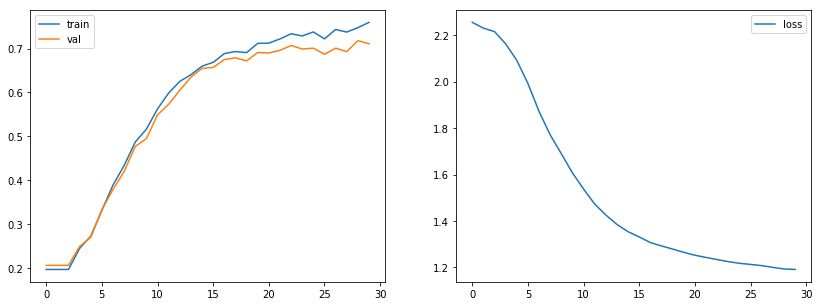

In [25]:
display_history(train_history, val_history, loss_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [53]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = .25e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=.3e-1, learning_rate_decay=0.99, num_epochs=30)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Epoch: 1, Loss: 2.253221, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, Loss: 2.229436, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, Loss: 2.195210, Train accuracy: 0.202667, val accuracy: 0.213000
Epoch: 4, Loss: 2.122804, Train accuracy: 0.272111, val accuracy: 0.275000
Epoch: 5, Loss: 2.023819, Train accuracy: 0.306889, val accuracy: 0.306000
Epoch: 6, Loss: 1.882657, Train accuracy: 0.394000, val accuracy: 0.376000
Epoch: 7, Loss: 1.749301, Train accuracy: 0.469333, val accuracy: 0.463000
Epoch: 8, Loss: 1.648048, Train accuracy: 0.523889, val accuracy: 0.516000
Epoch: 9, Loss: 1.563730, Train accuracy: 0.543556, val accuracy: 0.541000
Epoch: 10, Loss: 1.494024, Train accuracy: 0.597556, val accuracy: 0.591000
Epoch: 11, Loss: 1.433830, Train accuracy: 0.603778, val accuracy: 0.598000
Epoch: 12, Loss: 1.387079, Train accuracy: 0.641111, val accuracy: 0.644000
Epoch: 13, Loss: 1.352229, Train accuracy: 0.666444, val accuracy: 0.654000
Epoch: 14, Loss: 1.32

# display_history(train_history, val_history, loss_history)

###### Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [38]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 16e-4)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(momentum=.85), learning_rate=5e-3, 
                  learning_rate_decay=0.99, num_epochs=20)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch: 1, Loss: 2.250272, Train accuracy: 0.196667, Val accuracy: 0.206000
Epoch: 2, Loss: 2.226532, Train accuracy: 0.196667, Val accuracy: 0.206000
Epoch: 3, Loss: 2.180085, Train accuracy: 0.223778, Val accuracy: 0.225000
Epoch: 4, Loss: 2.086307, Train accuracy: 0.277333, Val accuracy: 0.278000
Epoch: 5, Loss: 1.941579, Train accuracy: 0.352444, Val accuracy: 0.356000
Epoch: 6, Loss: 1.770196, Train accuracy: 0.435111, Val accuracy: 0.433000
Epoch: 7, Loss: 1.647794, Train accuracy: 0.496889, Val accuracy: 0.465000
Epoch: 8, Loss: 1.556215, Train accuracy: 0.557333, Val accuracy: 0.536000
Epoch: 9, Loss: 1.466180, Train accuracy: 0.591444, Val accuracy: 0.570000
Epoch: 10, Loss: 1.385416, Train accuracy: 0.632444, Val accuracy: 0.597000
Epoch: 11, Loss: 1.324342, Train accuracy: 0.639000, Val accuracy: 0.610000
Epoch: 12, Loss: 1.280826, Train accuracy: 0.670778, Val accuracy: 0.652000
Epoch: 13, Loss: 1.242272, Train accuracy: 0.685333, Val accuracy: 0.662000
Epoch: 14, Loss: 1.21

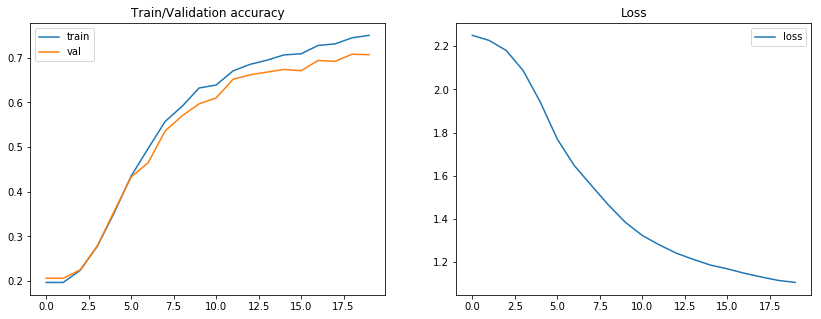

In [39]:
display_history(train_history, val_history, loss_history)

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [36]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.335755, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.326342, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.309442, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299321, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.290999, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.278685, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.264226, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.248465, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.199292, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.147894, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.061874, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.040482, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.940365, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.867840, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.898471, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.854052, Train acc

Loss: 1.270900, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.255551, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.249895, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.248350, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.255566, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.250326, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.275530, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.266453, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.261845, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.262012, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.252029, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.250878, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.246807, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.257124, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.271094, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.252507, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [40]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = .25e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=3e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.309810, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.287178, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.236027, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.112532, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.066487, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.758764, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.641560, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 1.632801, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.474697, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.353838, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 1.286296, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 1.269594, Train accuracy: 0.600000, val accuracy: 0.066667
Loss: 1.123230, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 0.749725, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 0.663399, Train accuracy: 0.800000, val accuracy: 0.066667
Loss: 0.694323, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **40%** на validation set.

In [ ]:
from itertools import product
from tqdm import tqdm_notebook
# Let's train the best one-hidden-layer network we can

learning_rates = 5e-3 * 10**np.random.uniform(-.5, .5, 5)
reg_strength = 16e-4 * 10**np.random.uniform(-.5, .5, 5)
learning_rate_decay = 0.99
hidden_layer_size = 100
num_epochs = 100


best_classifier = None
best_trainer = None
best_val_accuracy = 0

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
dataset = Dataset(train_X, train_y, val_X, val_y)
for lr, rs in tqdm_notebook(list(product(learning_rates, reg_strength))):
    print('----------')
    print('Learning Rate: %.6f, Regularization: %.6f' % (lr, rs))
    print('----------')
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, 
                        hidden_layer_size = hidden_layer_size, reg = rs)
    trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, 
                      learning_rate_decay=learning_rate_decay, num_epochs=num_epochs)
    max_val_accuracy = max(trainer.fit()[2])
    if(max_val_accuracy > best_val_accuracy):
        best_val_accuracy = max_val_accuracy
        best_classifier = model
        best_trainer = trainer

print('best validation accuracy achieved: %f' % best_val_accuracy)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [36]:
test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.777000
